In [9]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1
## GPU 없으면 CPU로 돌아가게끔 설정

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator, DLinearEstimator, TemporalFusionTransformerEstimator

TARGET_COLUMN = 'S&P 500 Financials.csv_Open'
DATASET_PATH = 'data/merged/merged_S&P 500 Financials.csv'

In [14]:
# Load data from a CSV file into a PandasDataset
df = pd.read_csv(
    DATASET_PATH,
    index_col=0,
    parse_dates=True,
)

# 중복 데이터 제거
duplicate_rows = df[df.duplicated(keep=False)]
df = df.drop_duplicates().drop(columns=['bitcoin_time'])

# 모든 날짜가 균일하게 분포되도록 interpolate 진행 
all_times = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_times)
df = df.interpolate(method='linear')

df.to_csv(f'data/processed/{DATASET_PATH.split("/")[-1]}')


/var/folders/9d/xf5zmlhd1ssbgpgvdsc55t940000gn/T/ipykernel_99451/648301607.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear')


In [18]:

dataset = PandasDataset(df, freq='D',target=TARGET_COLUMN)

# 22 년도 기준으로 데이터 분할, training dataset
training_data, test_gen = split(dataset,date=pd.Period('2023-01-01'))
test_data = test_gen.generate_instances(prediction_length=200, windows=20)


In [19]:
# Estimator 는 Predic
# arModel = DeepAREstimator(
#     prediction_length=20, freq="D", trainer_kwargs={"max_epochs": 200}
# ).train(training_data)


tftModel = TemporalFusionTransformerEstimator(
    prediction_length=20, freq="D", trainer_kwargs={"max_epochs": 200}
).train(training_data)




GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/namjihyeon/.pyenv/versions/3.10.13/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type                           | Params | In sizes                                                                           | Out sizes                     
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 109 K  | [[1, 20], [1, 20], [1, 1], [1, 1], [1, 40, 3], [1, 40, 0], [1, 20, 0], [1, 20, 0]] | [[[1, 20, 9]], [1, 1], [1, 1]]
---------------------------------------------------------------------------------------------------------------------------

Epoch 0: |          | 50/? [00:05<00:00,  9.45it/s, v_num=56, train_loss=0.906]

Epoch 0, global step 50: 'train_loss' reached 0.90596 (best 0.90596), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:05<00:00,  9.38it/s, v_num=56, train_loss=0.764]

Epoch 1, global step 100: 'train_loss' reached 0.76434 (best 0.76434), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:05<00:00,  8.63it/s, v_num=56, train_loss=0.713]

Epoch 2, global step 150: 'train_loss' reached 0.71250 (best 0.71250), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:05<00:00,  8.94it/s, v_num=56, train_loss=0.714]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: |          | 50/? [00:06<00:00,  8.24it/s, v_num=56, train_loss=0.678]

Epoch 4, global step 250: 'train_loss' reached 0.67763 (best 0.67763), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:05<00:00,  9.14it/s, v_num=56, train_loss=0.665]

Epoch 5, global step 300: 'train_loss' reached 0.66451 (best 0.66451), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:05<00:00,  8.57it/s, v_num=56, train_loss=0.661]

Epoch 6, global step 350: 'train_loss' reached 0.66102 (best 0.66102), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:06<00:00,  8.20it/s, v_num=56, train_loss=0.638]

Epoch 7, global step 400: 'train_loss' reached 0.63768 (best 0.63768), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:05<00:00,  8.56it/s, v_num=56, train_loss=0.701]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:05<00:00,  9.18it/s, v_num=56, train_loss=0.674]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |          | 50/? [00:05<00:00,  8.53it/s, v_num=56, train_loss=0.608]

Epoch 10, global step 550: 'train_loss' reached 0.60798 (best 0.60798), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:05<00:00,  8.89it/s, v_num=56, train_loss=0.645]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:05<00:00,  8.77it/s, v_num=56, train_loss=0.592]

Epoch 12, global step 650: 'train_loss' reached 0.59174 (best 0.59174), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=12-step=650.ckpt' as top 1


Epoch 13: |          | 50/? [00:05<00:00,  8.92it/s, v_num=56, train_loss=0.624]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:05<00:00,  8.80it/s, v_num=56, train_loss=0.602]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:05<00:00,  8.58it/s, v_num=56, train_loss=0.579]

Epoch 15, global step 800: 'train_loss' reached 0.57874 (best 0.57874), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:05<00:00,  8.80it/s, v_num=56, train_loss=0.555]

Epoch 16, global step 850: 'train_loss' reached 0.55462 (best 0.55462), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:05<00:00,  8.83it/s, v_num=56, train_loss=0.610]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:05<00:00,  9.23it/s, v_num=56, train_loss=0.600]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:05<00:00,  8.43it/s, v_num=56, train_loss=0.586]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:05<00:00,  9.12it/s, v_num=56, train_loss=0.539]

Epoch 20, global step 1050: 'train_loss' reached 0.53865 (best 0.53865), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:05<00:00,  8.74it/s, v_num=56, train_loss=0.531]

Epoch 21, global step 1100: 'train_loss' reached 0.53078 (best 0.53078), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=21-step=1100.ckpt' as top 1


Epoch 22: |          | 50/? [00:05<00:00,  9.35it/s, v_num=56, train_loss=0.547]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:05<00:00,  8.52it/s, v_num=56, train_loss=0.533]

Epoch 23, global step 1200: 'train_loss' was not in top 1


Epoch 24: |          | 50/? [00:05<00:00,  9.32it/s, v_num=56, train_loss=0.497]

Epoch 24, global step 1250: 'train_loss' reached 0.49736 (best 0.49736), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [00:05<00:00,  8.65it/s, v_num=56, train_loss=0.518]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:05<00:00,  9.41it/s, v_num=56, train_loss=0.489]

Epoch 26, global step 1350: 'train_loss' reached 0.48884 (best 0.48884), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=26-step=1350.ckpt' as top 1


Epoch 27: |          | 50/? [00:06<00:00,  8.18it/s, v_num=56, train_loss=0.462]

Epoch 27, global step 1400: 'train_loss' reached 0.46223 (best 0.46223), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=27-step=1400.ckpt' as top 1


Epoch 28: |          | 50/? [00:05<00:00,  8.79it/s, v_num=56, train_loss=0.516]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:05<00:00,  8.98it/s, v_num=56, train_loss=0.533]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:05<00:00,  8.83it/s, v_num=56, train_loss=0.449]

Epoch 30, global step 1550: 'train_loss' reached 0.44880 (best 0.44880), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=30-step=1550.ckpt' as top 1


Epoch 31: |          | 50/? [00:05<00:00,  8.98it/s, v_num=56, train_loss=0.429]

Epoch 31, global step 1600: 'train_loss' reached 0.42896 (best 0.42896), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [00:05<00:00,  8.73it/s, v_num=56, train_loss=0.449]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:05<00:00,  9.10it/s, v_num=56, train_loss=0.412]

Epoch 33, global step 1700: 'train_loss' reached 0.41192 (best 0.41192), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=33-step=1700.ckpt' as top 1


Epoch 34: |          | 50/? [00:05<00:00,  8.41it/s, v_num=56, train_loss=0.428]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:05<00:00,  9.19it/s, v_num=56, train_loss=0.431]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:05<00:00,  8.56it/s, v_num=56, train_loss=0.436]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:05<00:00,  9.18it/s, v_num=56, train_loss=0.398]

Epoch 37, global step 1900: 'train_loss' reached 0.39782 (best 0.39782), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=37-step=1900.ckpt' as top 1


Epoch 38: |          | 50/? [00:05<00:00,  8.57it/s, v_num=56, train_loss=0.400]

Epoch 38, global step 1950: 'train_loss' was not in top 1


Epoch 39: |          | 50/? [00:05<00:00,  9.01it/s, v_num=56, train_loss=0.389]

Epoch 39, global step 2000: 'train_loss' reached 0.38942 (best 0.38942), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:05<00:00,  8.89it/s, v_num=56, train_loss=0.417]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:05<00:00,  8.79it/s, v_num=56, train_loss=0.424]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:05<00:00,  8.84it/s, v_num=56, train_loss=0.369]

Epoch 42, global step 2150: 'train_loss' reached 0.36885 (best 0.36885), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=42-step=2150.ckpt' as top 1


Epoch 43: |          | 50/? [00:05<00:00,  8.76it/s, v_num=56, train_loss=0.361]

Epoch 43, global step 2200: 'train_loss' reached 0.36119 (best 0.36119), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=43-step=2200.ckpt' as top 1


Epoch 44: |          | 50/? [00:05<00:00,  9.16it/s, v_num=56, train_loss=0.386]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:05<00:00,  8.78it/s, v_num=56, train_loss=0.427]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:05<00:00,  8.87it/s, v_num=56, train_loss=0.396]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:05<00:00,  8.72it/s, v_num=56, train_loss=0.350]

Epoch 47, global step 2400: 'train_loss' reached 0.34993 (best 0.34993), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=47-step=2400.ckpt' as top 1


Epoch 48: |          | 50/? [00:05<00:00,  9.25it/s, v_num=56, train_loss=0.337]

Epoch 48, global step 2450: 'train_loss' reached 0.33700 (best 0.33700), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=48-step=2450.ckpt' as top 1


Epoch 49: |          | 50/? [00:05<00:00,  8.74it/s, v_num=56, train_loss=0.332]

Epoch 49, global step 2500: 'train_loss' reached 0.33238 (best 0.33238), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=49-step=2500.ckpt' as top 1


Epoch 50: |          | 50/? [00:05<00:00,  9.11it/s, v_num=56, train_loss=0.325]

Epoch 50, global step 2550: 'train_loss' reached 0.32530 (best 0.32530), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=50-step=2550.ckpt' as top 1


Epoch 51: |          | 50/? [00:05<00:00,  8.69it/s, v_num=56, train_loss=0.343]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: |          | 50/? [00:05<00:00,  9.26it/s, v_num=56, train_loss=0.325]

Epoch 52, global step 2650: 'train_loss' reached 0.32529 (best 0.32529), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=52-step=2650.ckpt' as top 1


Epoch 53: |          | 50/? [00:05<00:00,  8.65it/s, v_num=56, train_loss=0.372]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: |          | 50/? [00:05<00:00,  9.06it/s, v_num=56, train_loss=0.313]

Epoch 54, global step 2750: 'train_loss' reached 0.31275 (best 0.31275), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=54-step=2750.ckpt' as top 1


Epoch 55: |          | 50/? [00:05<00:00,  8.70it/s, v_num=56, train_loss=0.300]

Epoch 55, global step 2800: 'train_loss' reached 0.29998 (best 0.29998), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=55-step=2800.ckpt' as top 1


Epoch 56: |          | 50/? [00:05<00:00,  9.03it/s, v_num=56, train_loss=0.322]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: |          | 50/? [00:05<00:00,  8.75it/s, v_num=56, train_loss=0.317]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: |          | 50/? [00:05<00:00,  8.73it/s, v_num=56, train_loss=0.296]

Epoch 58, global step 2950: 'train_loss' reached 0.29554 (best 0.29554), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=58-step=2950.ckpt' as top 1


Epoch 59: |          | 50/? [00:05<00:00,  9.01it/s, v_num=56, train_loss=0.324]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: |          | 50/? [00:05<00:00,  8.90it/s, v_num=56, train_loss=0.300]

Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: |          | 50/? [00:05<00:00,  9.18it/s, v_num=56, train_loss=0.300]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: |          | 50/? [00:05<00:00,  8.59it/s, v_num=56, train_loss=0.291]

Epoch 62, global step 3150: 'train_loss' reached 0.29087 (best 0.29087), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=62-step=3150.ckpt' as top 1


Epoch 63: |          | 50/? [00:05<00:00,  9.23it/s, v_num=56, train_loss=0.296]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: |          | 50/? [00:05<00:00,  8.68it/s, v_num=56, train_loss=0.320]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: |          | 50/? [00:05<00:00,  9.07it/s, v_num=56, train_loss=0.310]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: |          | 50/? [00:05<00:00,  8.48it/s, v_num=56, train_loss=0.266]

Epoch 66, global step 3350: 'train_loss' reached 0.26596 (best 0.26596), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=66-step=3350.ckpt' as top 1


Epoch 67: |          | 50/? [00:05<00:00,  9.13it/s, v_num=56, train_loss=0.272]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: |          | 50/? [00:05<00:00,  8.80it/s, v_num=56, train_loss=0.292]

Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: |          | 50/? [00:05<00:00,  9.13it/s, v_num=56, train_loss=0.295]

Epoch 69, global step 3500: 'train_loss' was not in top 1


Epoch 70: |          | 50/? [00:05<00:00,  8.72it/s, v_num=56, train_loss=0.265]

Epoch 70, global step 3550: 'train_loss' reached 0.26452 (best 0.26452), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=70-step=3550.ckpt' as top 1


Epoch 71: |          | 50/? [00:05<00:00,  8.73it/s, v_num=56, train_loss=0.262]

Epoch 71, global step 3600: 'train_loss' reached 0.26152 (best 0.26152), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=71-step=3600.ckpt' as top 1


Epoch 72: |          | 50/? [00:05<00:00,  8.80it/s, v_num=56, train_loss=0.266]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: |          | 50/? [00:05<00:00,  8.59it/s, v_num=56, train_loss=0.292]

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: |          | 50/? [00:05<00:00,  9.10it/s, v_num=56, train_loss=0.274]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: |          | 50/? [00:06<00:00,  7.70it/s, v_num=56, train_loss=0.286]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: |          | 50/? [00:05<00:00,  8.81it/s, v_num=56, train_loss=0.283]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: |          | 50/? [00:05<00:00,  8.70it/s, v_num=56, train_loss=0.287]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: |          | 50/? [00:05<00:00,  9.26it/s, v_num=56, train_loss=0.249]

Epoch 78, global step 3950: 'train_loss' reached 0.24915 (best 0.24915), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=78-step=3950.ckpt' as top 1


Epoch 79: |          | 50/? [00:05<00:00,  8.58it/s, v_num=56, train_loss=0.264]

Epoch 79, global step 4000: 'train_loss' was not in top 1


Epoch 80: |          | 50/? [00:05<00:00,  9.01it/s, v_num=56, train_loss=0.261]

Epoch 80, global step 4050: 'train_loss' was not in top 1


Epoch 81: |          | 50/? [00:05<00:00,  8.60it/s, v_num=56, train_loss=0.261]

Epoch 81, global step 4100: 'train_loss' was not in top 1


Epoch 82: |          | 50/? [00:05<00:00,  9.25it/s, v_num=56, train_loss=0.254]

Epoch 82, global step 4150: 'train_loss' was not in top 1


Epoch 83: |          | 50/? [00:05<00:00,  8.59it/s, v_num=56, train_loss=0.238]

Epoch 83, global step 4200: 'train_loss' reached 0.23835 (best 0.23835), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=83-step=4200.ckpt' as top 1


Epoch 84: |          | 50/? [00:05<00:00,  8.59it/s, v_num=56, train_loss=0.257]

Epoch 84, global step 4250: 'train_loss' was not in top 1


Epoch 85: |          | 50/? [00:05<00:00,  8.80it/s, v_num=56, train_loss=0.241]

Epoch 85, global step 4300: 'train_loss' was not in top 1


Epoch 86: |          | 50/? [00:05<00:00,  8.79it/s, v_num=56, train_loss=0.252]

Epoch 86, global step 4350: 'train_loss' was not in top 1


Epoch 87: |          | 50/? [00:06<00:00,  7.26it/s, v_num=56, train_loss=0.249]

Epoch 87, global step 4400: 'train_loss' was not in top 1


Epoch 88: |          | 50/? [00:05<00:00,  8.83it/s, v_num=56, train_loss=0.232]

Epoch 88, global step 4450: 'train_loss' reached 0.23235 (best 0.23235), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=88-step=4450.ckpt' as top 1


Epoch 89: |          | 50/? [00:05<00:00,  9.56it/s, v_num=56, train_loss=0.276]

Epoch 89, global step 4500: 'train_loss' was not in top 1


Epoch 90: |          | 50/? [00:05<00:00,  8.98it/s, v_num=56, train_loss=0.222]

Epoch 90, global step 4550: 'train_loss' reached 0.22159 (best 0.22159), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=90-step=4550.ckpt' as top 1


Epoch 91: |          | 50/? [00:05<00:00,  9.53it/s, v_num=56, train_loss=0.232]

Epoch 91, global step 4600: 'train_loss' was not in top 1


Epoch 92: |          | 50/? [00:05<00:00,  8.99it/s, v_num=56, train_loss=0.255]

Epoch 92, global step 4650: 'train_loss' was not in top 1


Epoch 93: |          | 50/? [00:05<00:00,  9.61it/s, v_num=56, train_loss=0.252]

Epoch 93, global step 4700: 'train_loss' was not in top 1


Epoch 94: |          | 50/? [00:05<00:00,  9.18it/s, v_num=56, train_loss=0.223]

Epoch 94, global step 4750: 'train_loss' was not in top 1


Epoch 95: |          | 50/? [00:05<00:00,  9.70it/s, v_num=56, train_loss=0.255]

Epoch 95, global step 4800: 'train_loss' was not in top 1


Epoch 96: |          | 50/? [00:05<00:00,  8.96it/s, v_num=56, train_loss=0.259]

Epoch 96, global step 4850: 'train_loss' was not in top 1


Epoch 97: |          | 50/? [00:05<00:00,  9.72it/s, v_num=56, train_loss=0.227]

Epoch 97, global step 4900: 'train_loss' was not in top 1


Epoch 98: |          | 50/? [00:05<00:00,  9.04it/s, v_num=56, train_loss=0.256]

Epoch 98, global step 4950: 'train_loss' was not in top 1


Epoch 99: |          | 50/? [00:05<00:00,  9.59it/s, v_num=56, train_loss=0.231]

Epoch 99, global step 5000: 'train_loss' was not in top 1


Epoch 100: |          | 50/? [00:05<00:00,  9.03it/s, v_num=56, train_loss=0.247]

Epoch 100, global step 5050: 'train_loss' was not in top 1


Epoch 101: |          | 50/? [00:05<00:00,  9.58it/s, v_num=56, train_loss=0.223]

Epoch 101, global step 5100: 'train_loss' was not in top 1


Epoch 102: |          | 50/? [00:06<00:00,  7.69it/s, v_num=56, train_loss=0.222]

Epoch 102, global step 5150: 'train_loss' was not in top 1


Epoch 103: |          | 50/? [14:22<00:00,  0.06it/s, v_num=56, train_loss=0.199]

Epoch 103, global step 5200: 'train_loss' reached 0.19860 (best 0.19860), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=103-step=5200.ckpt' as top 1


Epoch 104: |          | 50/? [00:08<00:00,  5.75it/s, v_num=56, train_loss=0.197]

Epoch 104, global step 5250: 'train_loss' reached 0.19703 (best 0.19703), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=104-step=5250.ckpt' as top 1


Epoch 105: |          | 50/? [00:06<00:00,  7.52it/s, v_num=56, train_loss=0.195]

Epoch 105, global step 5300: 'train_loss' reached 0.19468 (best 0.19468), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=105-step=5300.ckpt' as top 1


Epoch 106: |          | 50/? [00:06<00:00,  7.78it/s, v_num=56, train_loss=0.204]

Epoch 106, global step 5350: 'train_loss' was not in top 1


Epoch 107: |          | 50/? [00:07<00:00,  6.41it/s, v_num=56, train_loss=0.205]

Epoch 107, global step 5400: 'train_loss' was not in top 1


Epoch 108: |          | 50/? [00:06<00:00,  7.63it/s, v_num=56, train_loss=0.210]

Epoch 108, global step 5450: 'train_loss' was not in top 1


Epoch 109: |          | 50/? [00:06<00:00,  7.64it/s, v_num=56, train_loss=0.217]

Epoch 109, global step 5500: 'train_loss' was not in top 1


Epoch 110: |          | 50/? [00:06<00:00,  7.57it/s, v_num=56, train_loss=0.251]

Epoch 110, global step 5550: 'train_loss' was not in top 1


Epoch 111: |          | 50/? [00:06<00:00,  7.16it/s, v_num=56, train_loss=0.207]

Epoch 111, global step 5600: 'train_loss' was not in top 1


Epoch 112: |          | 50/? [00:09<00:00,  5.41it/s, v_num=56, train_loss=0.207]

Epoch 112, global step 5650: 'train_loss' was not in top 1


Epoch 113: |          | 50/? [00:07<00:00,  7.13it/s, v_num=56, train_loss=0.251]

Epoch 113, global step 5700: 'train_loss' was not in top 1


Epoch 114: |          | 50/? [00:08<00:00,  5.82it/s, v_num=56, train_loss=0.204]

Epoch 114, global step 5750: 'train_loss' was not in top 1


Epoch 115: |          | 50/? [00:06<00:00,  7.90it/s, v_num=56, train_loss=0.191]

Epoch 115, global step 5800: 'train_loss' reached 0.19120 (best 0.19120), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=115-step=5800.ckpt' as top 1


Epoch 116: |          | 50/? [00:11<00:00,  4.41it/s, v_num=56, train_loss=0.218]

Epoch 116, global step 5850: 'train_loss' was not in top 1


Epoch 117: |          | 50/? [00:05<00:00,  8.66it/s, v_num=56, train_loss=0.187]

Epoch 117, global step 5900: 'train_loss' reached 0.18650 (best 0.18650), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=117-step=5900.ckpt' as top 1


Epoch 118: |          | 50/? [00:07<00:00,  6.30it/s, v_num=56, train_loss=0.189]

Epoch 118, global step 5950: 'train_loss' was not in top 1


Epoch 119: |          | 50/? [00:06<00:00,  7.64it/s, v_num=56, train_loss=0.184]

Epoch 119, global step 6000: 'train_loss' reached 0.18394 (best 0.18394), saving model to '/Users/namjihyeon/IE471/lightning_logs/version_56/checkpoints/epoch=119-step=6000.ckpt' as top 1


Epoch 120: |          | 13/? [00:03<00:00,  3.82it/s, v_num=56, train_loss=0.184]

In [ ]:
forecasts = list(tftModel.predict(test_data.input))
print(len(forecasts))


3


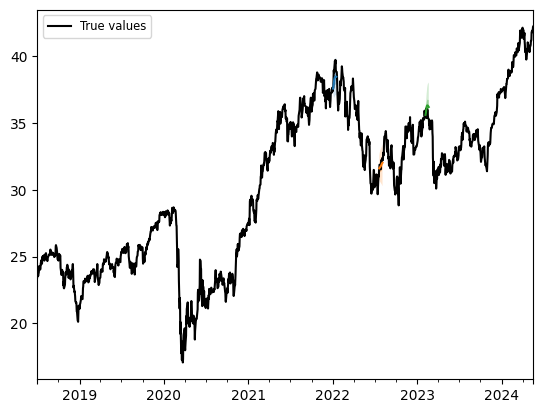

In [ ]:
# Plot predictions
plotting_df = df.loc[:, [TARGET_COLUMN]]
plotting_df.plot(color="black")
# plt.plot(df, color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="small")
plt.show()

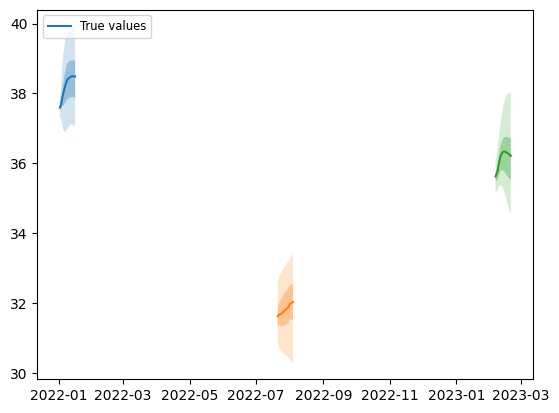

In [ ]:
# plt.plot(df, color="black")

for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="small")
plt.show()